# Galloping Timeseries

My friend Kevin asked:

> Anyone know how to easily make a timeseries chart [like this](https://fivethirtyeight.com/features/20-years-of-congresss-budget-procrastination-in-one-chart/):

> 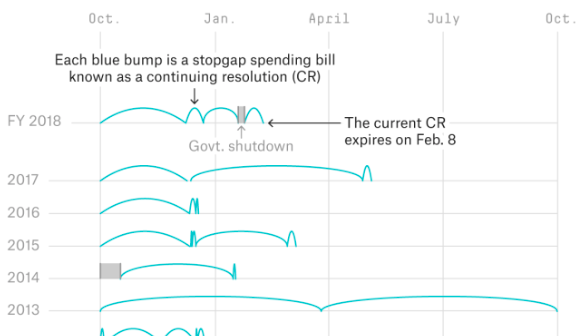

> Data is up to May 2023 [here](https://crsreports.congress.gov/product/pdf/R/R46595):




There's a lot of styling here, but the key idea seems to be:
> Insert an arc between all the _x_ points of a timeseries.

## Imports

In [ ]:
import numpy as np                                                                              
import matplotlib.pyplot as plt                                                                 
from typing import Iterable

## Copy Pasta

There is a [related answer](https://stackoverflow.com/questions/4047804/plotting-a-parabola-within-part-of-a-repeating-signal-using-numpy) from Joe Kington on StackExchange. Pasted here with minor mods to check the whole thing runs. The approach being proved, we'll only need the `fit_parabola()` method. 

His goal was to _replace bad y data_ with arcs -- specifically parabolas.

In [ ]:
def replace_data(x, y, left_idx, right_idx, min_idx):
    """Replace the section of "y" between the indicies "left_idx" and
    "right_idx" with a parabola fitted to the three x,y points represented
    by "left_idx", "min_idx", and "right_idx"."""
    x_fit = x[[left_idx, min_idx, right_idx]]
    y_fit = y[[left_idx, min_idx, right_idx]]
    a, b, c = fit_parabola(x_fit, y_fit)

    new_x = x[left_idx:right_idx]
    new_y = a * new_x**2 + b * new_x + c

    y = y.copy() # Remove this if you want to modify y in-place
    y[left_idx:right_idx] = new_y
    return y

That in turn called this (slightly modified) `fit_parabola()` function.

In [ ]:
def fit_parabola(x, y):
    """Fits the equation "y = ax^2 + bx + c" given exactly 3 points as two
    lists or arrays of x & y coordinates"""
    A = np.ones((3,3), dtype=float)
    A[:,0] = x**2
    A[:,1] = x
    a, b, c = np.linalg.solve(A, y)
    return a, b, c

And `main()` just generates random data and does the plotting.

In [ ]:
def main():
    # Generate some random data
    x = np.linspace(0, 10, 100)
    y = np.cumsum(np.random.random(100) - 0.5)

    # Just selecting these arbitrarly 
    left_idx, right_idx = 20, 50      
    # Using the mininum y-value within the arbitrary range
    min_idx = np.argmin(y[left_idx:right_idx]) + left_idx 

    # Replace the data within the range with a fitted parabola
    new_y = replace_data(x, y, left_idx, right_idx, min_idx)  

    # Plot the data
    fig = plt.figure()
    indicies = [left_idx, min_idx, right_idx]

    ax1 = fig.add_subplot(2, 1, 1)
    ax1.axvspan(x[left_idx], x[right_idx], facecolor='red', alpha=0.5)
    ax1.plot(x, y)                                                    
    ax1.plot(x[indicies], y[indicies], 'ro')                          

    ax2 = fig.add_subplot(2, 1, 2)
    ax2.axvspan(x[left_idx], x[right_idx], facecolor='red', alpha=0.5)
    ax2.plot(x,new_y)                                                 
    ax2.plot(x[indicies], y[indicies], 'ro')

    plt.show()

Like this:

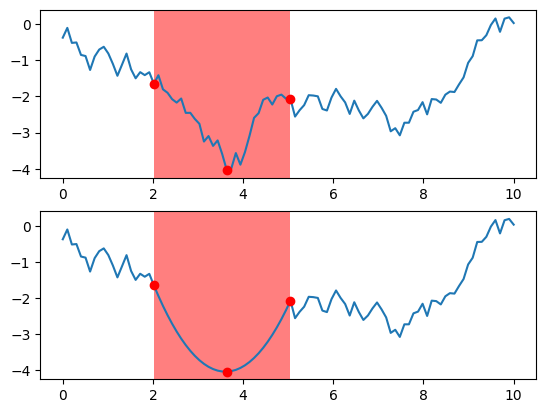

In [ ]:
main()

## Basic Gallop
Instead of _replacing_ data, we are _inserting_ it. Between each pair of _x_ points, insert a smooth parabola.  "Smooth" of course means 30 points. Height is arbitrary, but negative values allow **Swoop** instead of **Gallop**. We make the parabola symmetric between the $x$ points. 

In [ ]:
def gallop(x: Iterable, N=30, height=1) -> (Iterable, Iterable):
    """Draw smooth parabolas of `N` points between each pair of `x` points.
    `Height` controls height (or depth)
    
    """
    new_x, new_y = [], []
    for i in range(len(x)-1):
        x_lo, x_hi = x[[i, i+1]]
        x_fit = np.array([x_lo, (x_lo + x_hi)/2, x_hi])
        a, b, c = fit_parabola(x_fit, [0, height, 0])

        xtra = np.linspace(x_lo, x_hi, N)
        new_x.extend(xtra)
        new_y.extend(a * xtra**2 + b * xtra + c)
    return new_x, new_y

Create the parabolae.

In [ ]:
x = np.array(sorted(np.random.normal(5, 2, size=10)))
new_x, new_y = gallop(x)

And plot them.

(-1.0, 2.0)

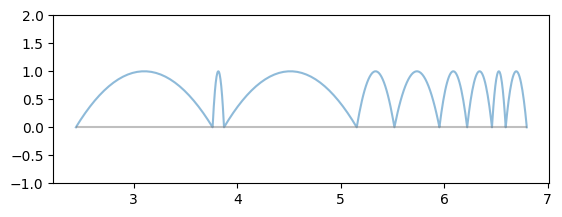

In [ ]:
fig = plt.figure()
ax1 = fig.add_subplot(2, 1, 1)
ax1.plot(new_x, new_y, alpha=.5)
ax1.hlines(0, x[0], x[-1], alpha=.5, color='gray')
plt.ylim(-1,2)

## ToDo
* Multiple plots on the same axis.
* Actual data.
* Nicer background grid.
* Gray bars non-gallop periods (shutdowns).
* Annotations?